In [1]:
import numpy as np
import os
import pandas as pd
import cv2
from tqdm import tqdm
import io
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

import warnings

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.utils import shuffle # Shuffle arrays or sparse matrices in a consistent way
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential, load_model
from sklearn.metrics import classification_report, confusion_matrix
import warnings as wr
wr.filterwarnings('ignore')

In [2]:
labels = ['Glioma', 'Meningioma', 'Notumor', 'Pituitary']
IMG_SIZE = [224, 224]

In [3]:
#Training Dataset
X_train = []
#Training Labels
Y_train = []

img_size=224

for i in labels:
    dataset_path = os.path.join('dataset', 'Training', i)
    for j in tqdm(os.listdir(dataset_path)):
        image = cv2.imread(os.path.join(dataset_path, j))
        image = cv2.resize(image, (img_size, img_size))
        X_train.append(image)
        Y_train.append(i)
        
        
for i in labels:
    dataset_path = os.path.join('dataset', 'Testing', i) # Join two or more pathname components
    for j in tqdm(os.listdir(dataset_path)):
        image = cv2.imread(os.path.join(dataset_path, j))
        image = cv2.resize(image, (img_size, img_size))
        X_train.append(image)
        Y_train.append(i)

#Converting list into array
X_train = np.array(X_train)
Y_train = np.array(Y_train)

100%|██████████| 300/300 [00:00<00:00, 458.54it/s]


In [4]:
#Training dataset size
X_train.shape 

(7023, 224, 224, 3)

In [5]:
# Shuffling data
X_train, Y_train = shuffle(X_train, Y_train, random_state=42)

In [6]:
#After shuffling sample size remains same
X_train.shape

(7023, 224, 224, 3)

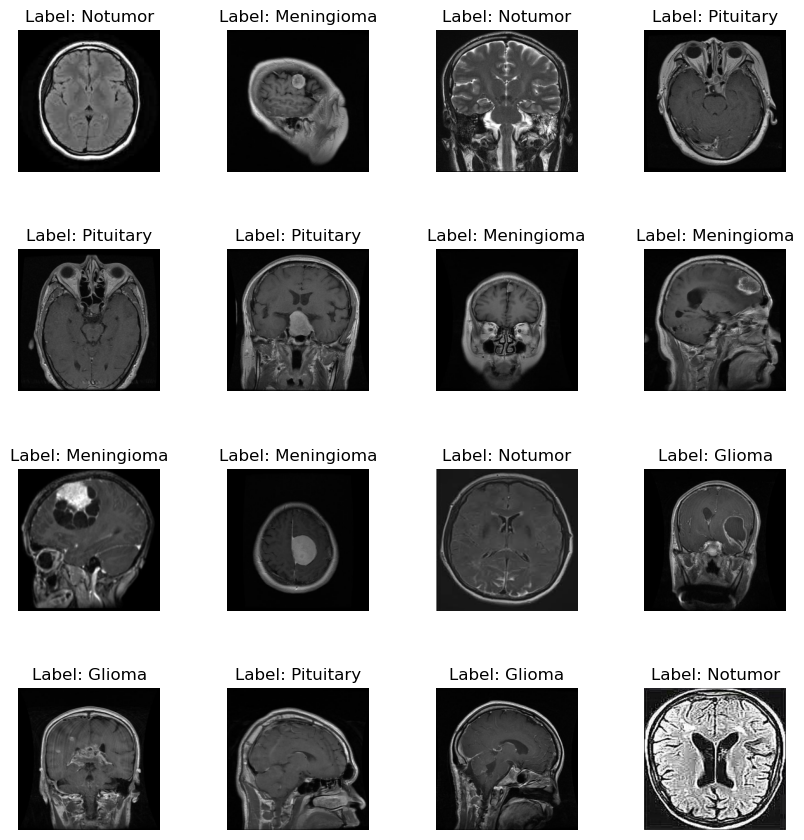

In [7]:
grid_w = 4
grid_h = 4
f, ax = plt.subplots(grid_w, grid_h)
f.set_size_inches(8, 8)

image_index = 0
for i in range(0, grid_w):
    for j in range(0, grid_h):
        ax[i][j].axis('off')
        ax[i][j].set_title('Label: '+Y_train[image_index])
        ax[i][j].imshow(X_train[image_index])
        image_index += 1

plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.2, hspace=0.55)  

In [8]:
X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

In [9]:
y_train_new = []
#y_valid_new = []
y_test_new = []

for i in Y_train:
    y_train_new.append(labels.index(i))
Y_train = to_categorical(y_train_new)



for i in Y_test:
    y_test_new.append(labels.index(i))

Y_test = to_categorical(y_test_new)

In [10]:
Y_train

array([[0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       ...,
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.]], dtype=float32)

In [11]:
vgg16 = VGG16(input_shape=IMG_SIZE + [3], weights='imagenet', include_top=False)
for layer in vgg16.layers:
  layer.trainable = False

In [12]:

x = Flatten()(vgg16.output)
prediction = Dense(4, activation='softmax')(x)
CNN_model = Model(inputs=vgg16.input, outputs=prediction)

In [13]:
CNN_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [14]:
CNN_model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [15]:
# Model Scaling
X_train_scaled = X_train.astype('float32')
X_test_scaled = X_test.astype('float32')


X_train_scaled /= 255
X_test_scaled /= 255

In [16]:
model_training = CNN_model.fit(x=X_train_scaled, y=Y_train,
                   validation_data=(X_test_scaled, Y_test),
                   batch_size=32,
                   epochs=2,
                   verbose=1)

Epoch 1/2
176/176 [==============================] - 1393s 8s/step - loss: 0.4427 - accuracy: 0.8430 - val_loss: 0.2302 - val_accuracy: 0.9025
Epoch 2/2
176/176 [==============================] - 876s 5s/step - loss: 0.1718 - accuracy: 0.9382 - val_loss: 0.2004 - val_accuracy: 0.9160


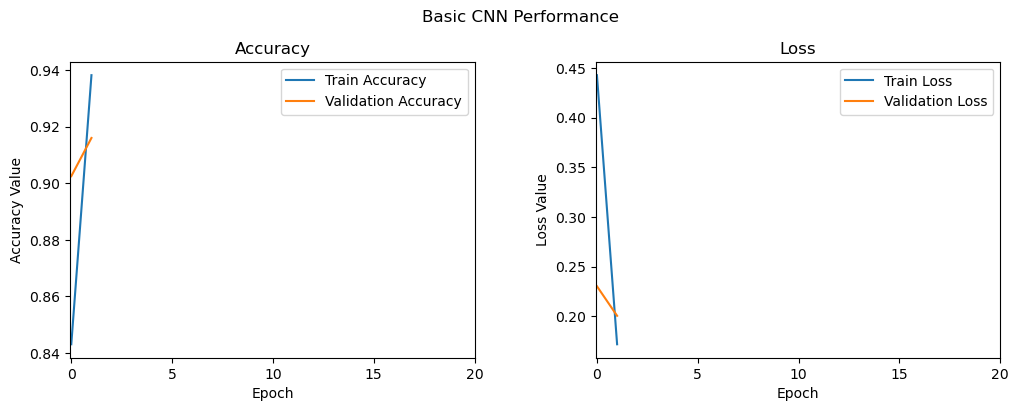

In [21]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Basic CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,21))
ax1.plot(model_training.history['accuracy'], label='Train Accuracy')
ax1.plot(model_training.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 21, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(model_training.history['loss'], label='Train Loss')
ax2.plot(model_training.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 21, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [23]:
# Getting model predictions
test_predictions = CNN_model.predict(X_test_scaled)
preds = np.argmax(test_predictions, axis=1)
actual_label = np.argmax(Y_test, axis=1)
print(classification_report(actual_label, preds))

44/44 [==============================] - 177s 4s/step
              precision    recall  f1-score   support

           0       0.83      0.97      0.90       310
           1       0.93      0.73      0.82       326
           2       0.97      0.98      0.97       419
           3       0.93      0.97      0.95       350

    accuracy                           0.92      1405
   macro avg       0.91      0.91      0.91      1405
weighted avg       0.92      0.92      0.91      1405



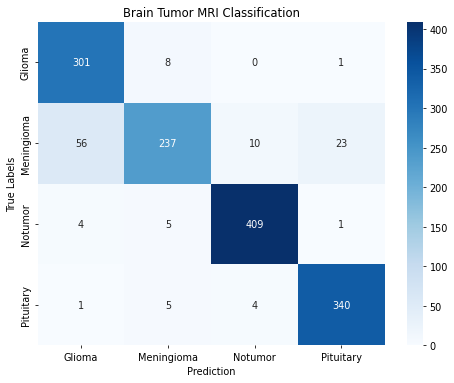

In [24]:
cnf = confusion_matrix(actual_label, preds)
plt.figure(figsize=(8,6), dpi=70, facecolor='w', edgecolor='k')
ax = sns.heatmap(cnf, cmap='Blues', annot=True, fmt = 'd', xticklabels=labels, yticklabels=labels)
plt.title('Brain Tumor MRI Classification')
plt.xlabel('Prediction')
plt.ylabel('True Labels')
plt.show(ax)

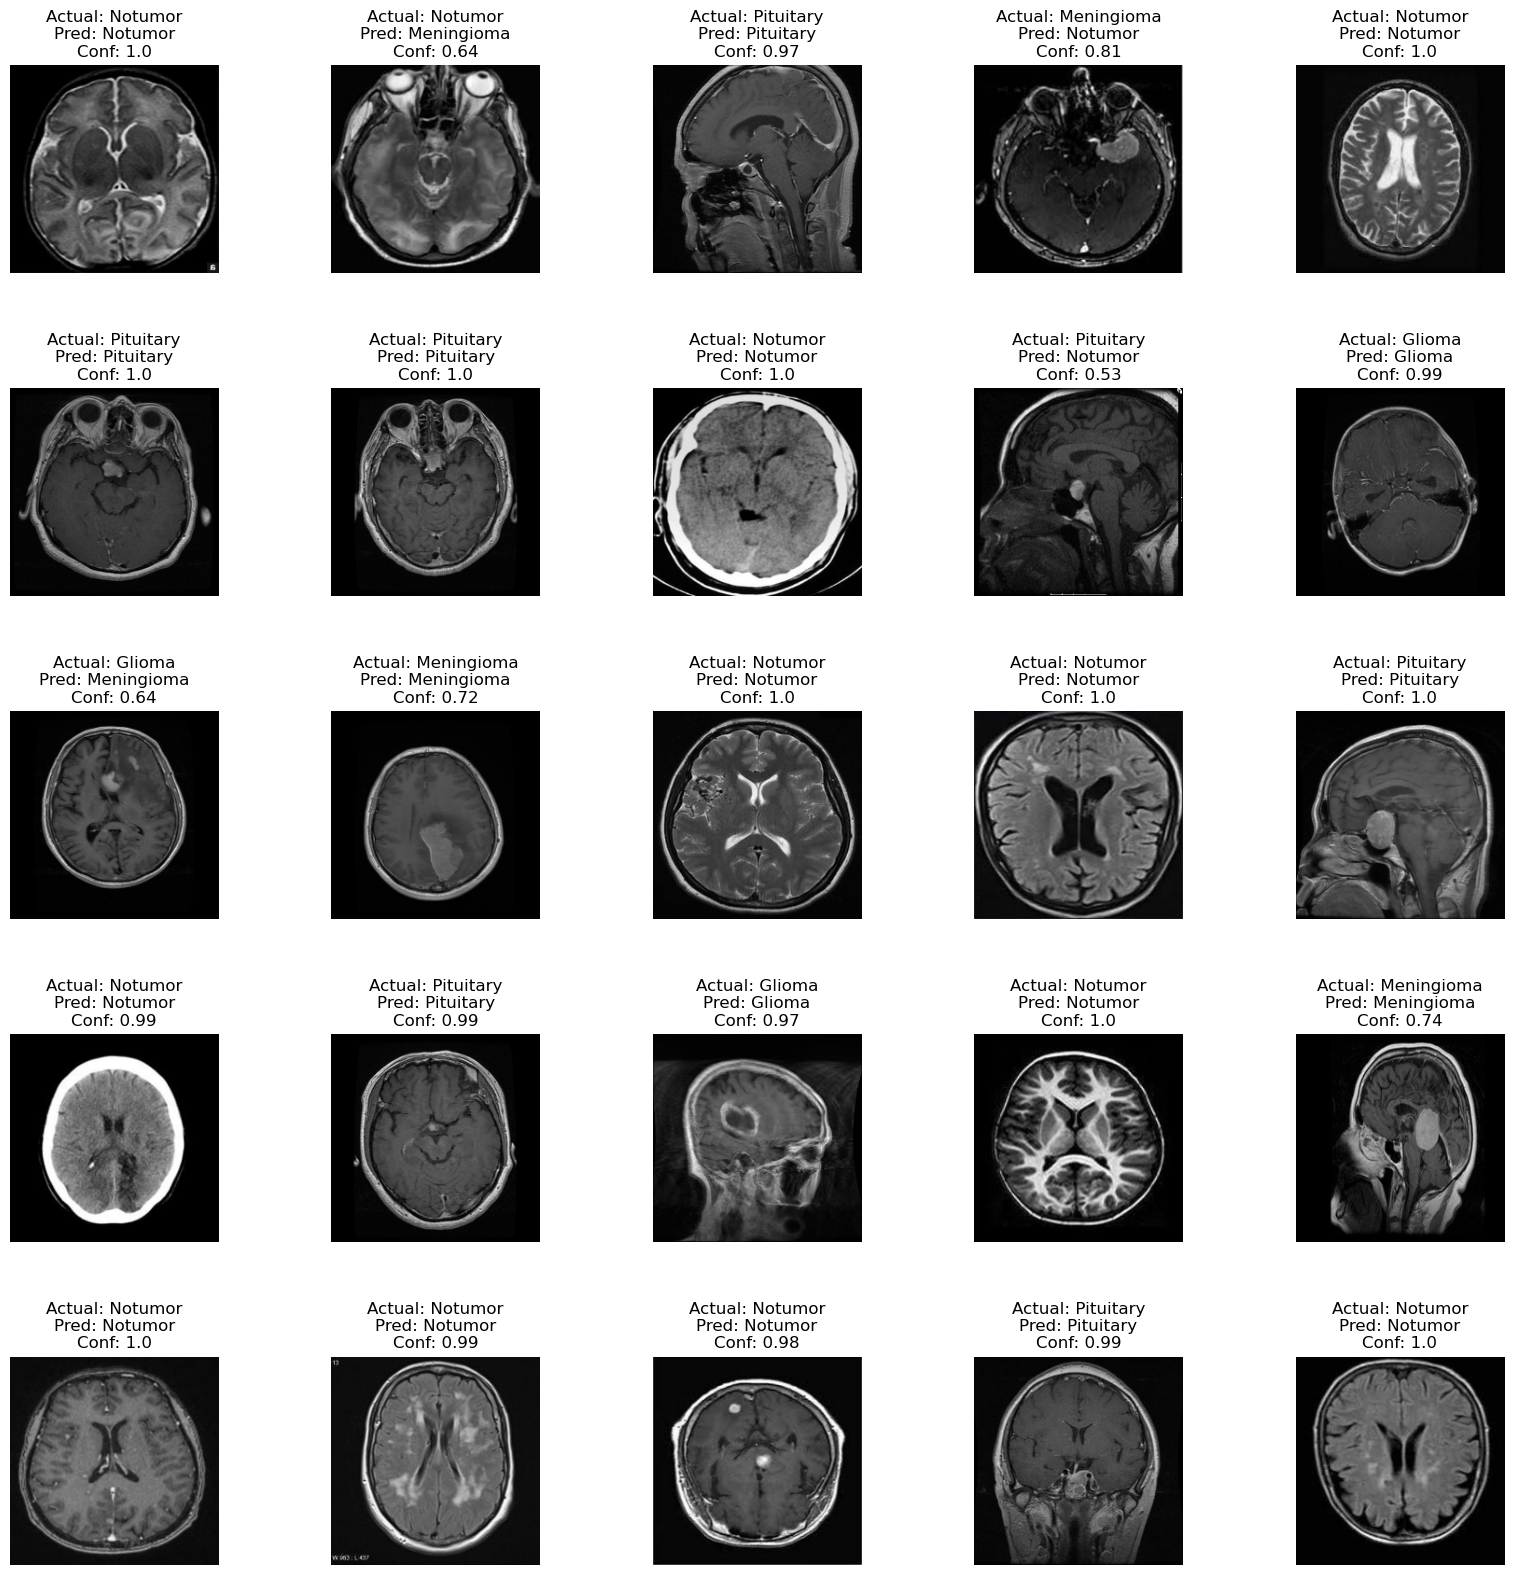

In [25]:
grid_w = 5
grid_h = 5
f, ax = plt.subplots(grid_w, grid_h)
f.set_size_inches(15, 15)

image_index = 0
for i in range(0, grid_w):
    for j in range(0, grid_h):
        actual = actual_label[image_index]
        predicted = preds[image_index]
        confidence = round(test_predictions[image_index][predicted], 2)
        ax[i][j].axis('off')
        ax[i][j].set_title('Actual: '+labels[actual]+'\nPred: '+labels[predicted] + '\nConf: ' +str(confidence))
        ax[i][j].imshow(X_test[image_index])
        image_index += 1

plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.5, hspace=0.55)   